In [14]:
import numpy as np
import pandas as pd
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import keras
from keras.engine.functional import Functional
from keras import layers
from sklearn.cluster import KMeans, DBSCAN
from sklearn import decomposition
from sklearn import manifold

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Import Data

In [15]:
df = pd.read_csv('../data/df_arabica_clean.csv')

attributes = [
    'Aroma',
    'Flavor',
    'Aftertaste',
    'Acidity',
    'Body',
    'Balance'
]

df = df[attributes]
df_numpy = df.to_numpy()
df.head()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance
0,8.58,8.50,8.42,8.58,8.25,8.42
1,8.50,8.50,7.92,8.00,7.92,8.25
2,8.33,8.42,8.08,8.17,7.92,8.17
3,8.08,8.17,8.17,8.25,8.17,8.08
4,8.33,8.33,8.08,8.25,7.92,7.92


# Relationships between each pair of independent variables

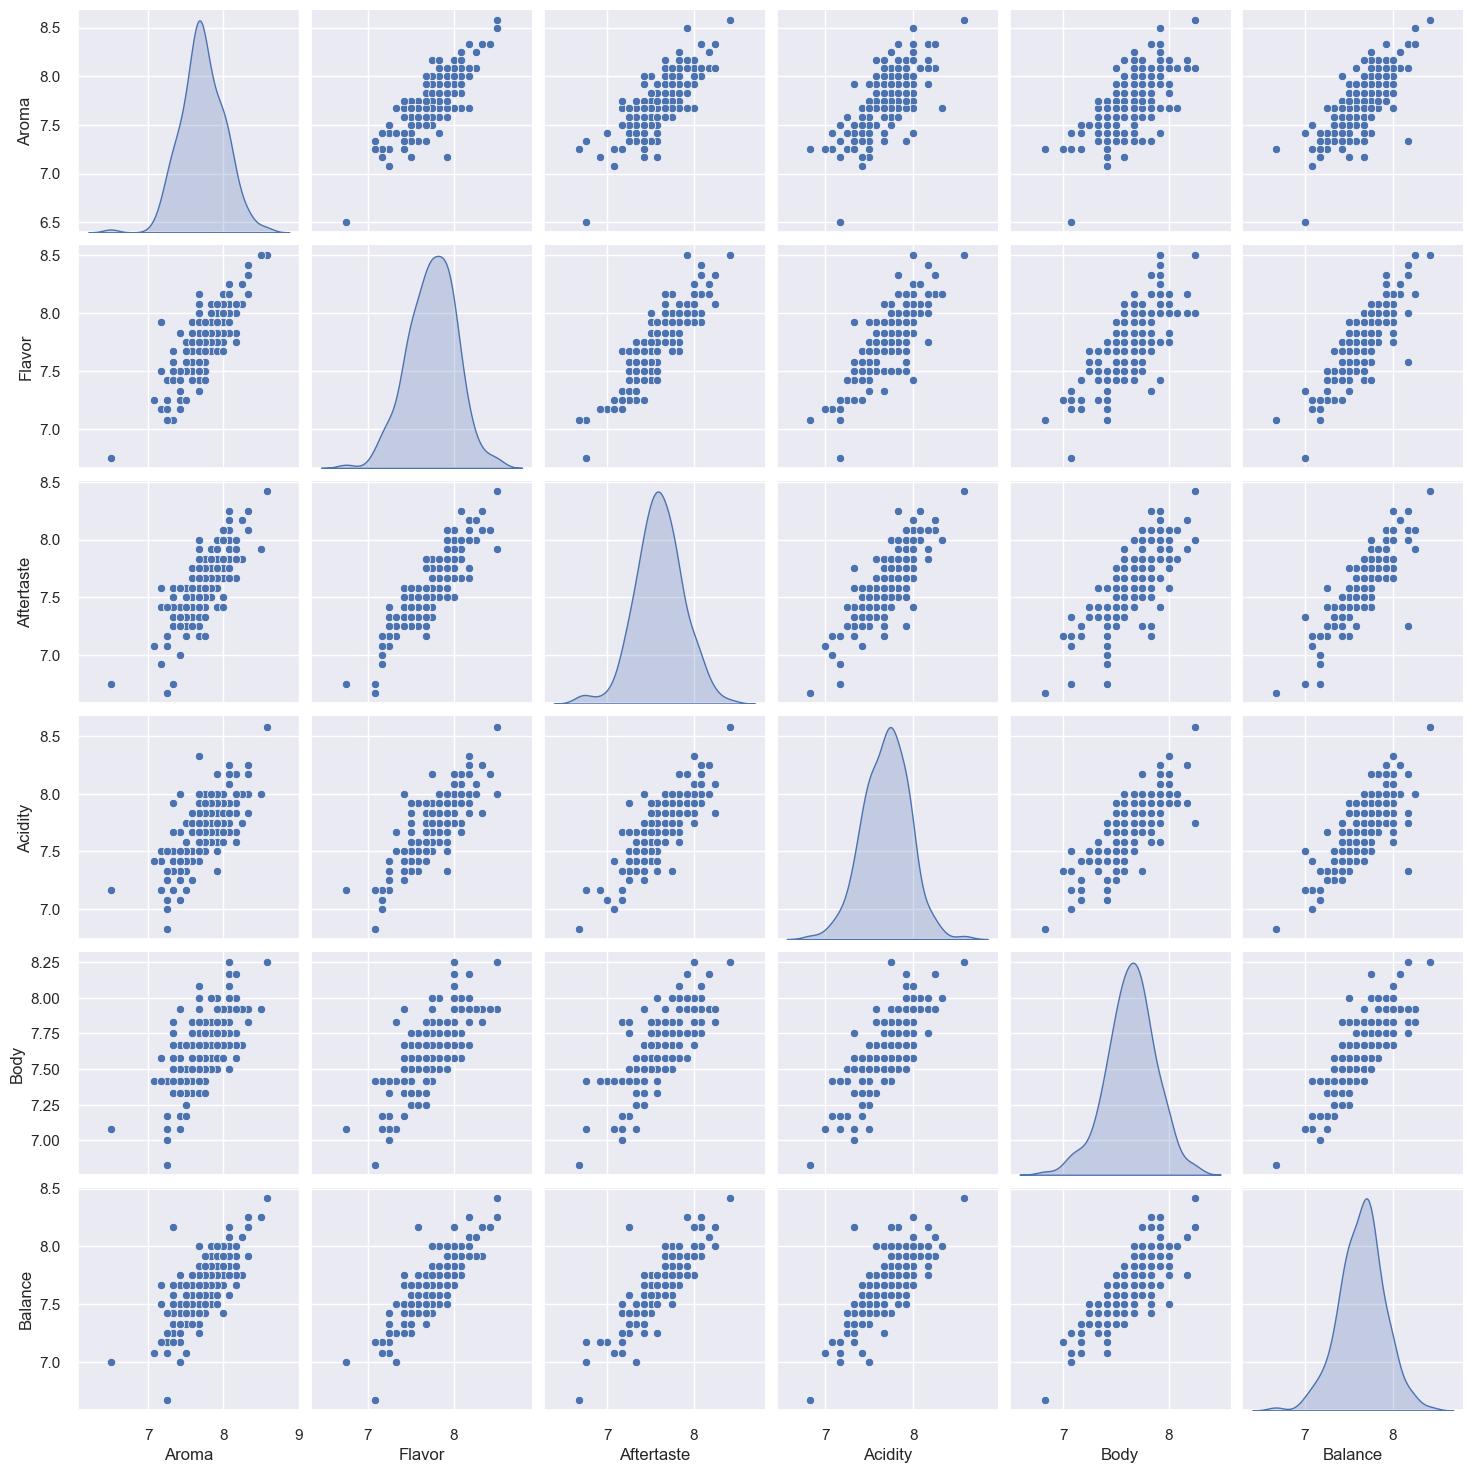

In [16]:
g = sns.pairplot(df, diag_kind="kde")

# Dimensionality reduction

## PCA

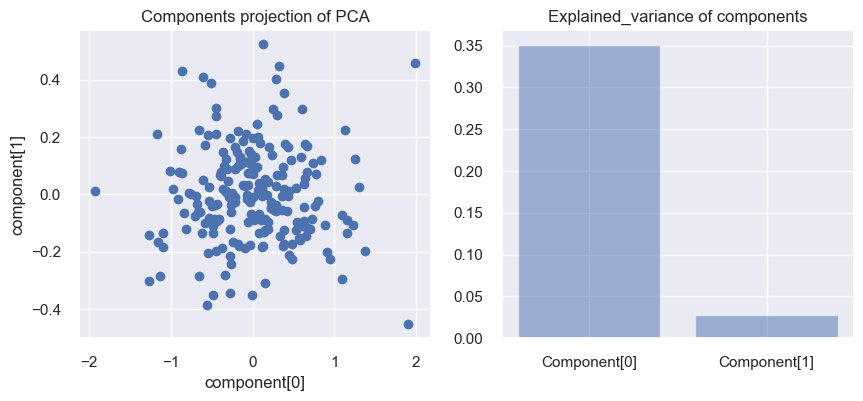

In [17]:
pca = decomposition.PCA(n_components=2)
pca_reduced = pca.fit_transform(df_numpy)
pca_variance = pca.explained_variance_

fig, (ax_viz, ax_variance) = plt.subplots(1, 2)
fig.set_size_inches((10, 4))

ax_viz.scatter(pca_reduced.T[0], pca_reduced.T[1])
ax_viz.set_xlabel('component[0]')
ax_viz.set_ylabel('component[1]')
ax_viz.set_title('Components projection of PCA')

ax_variance.bar(['Component[0]', 'Component[1]'], pca_variance, alpha=0.5, align='center', label='individual variance')
ax_variance.set_title('Explained_variance of components')

plt.show()

## TSNE

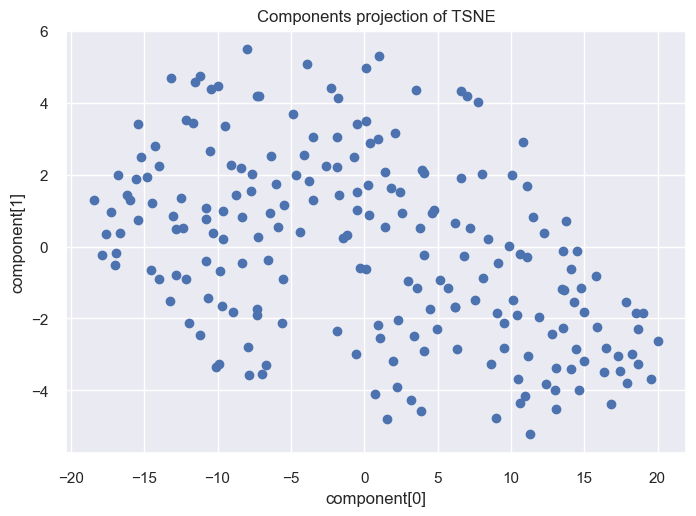

In [18]:
tsne = manifold.TSNE(n_components=2,
                     n_iter=500,
                     n_iter_without_progress=150,
                     n_jobs=2,
                     random_state=0,)
tsne_reduced = tsne.fit_transform(df_numpy)

plt.scatter(tsne_reduced.T[0], tsne_reduced.T[1])
plt.xlabel('component[0]')
plt.ylabel('component[1]')
plt.title('Components projection of TSNE')

plt.show()

# Neural Network dimension reducer with Autoencoder

## Network structure

In [21]:
class Autoencoder_DimReducer(Functional):
    def __init__(self, input_shape, latent_dim, layers_sizes = [32, 16, 8]):
        super(Functional, self).__init__()
        self.encoder_layers = [
            layers.Input(shape=(input_shape,)),
            *[layers.Dense(size, activation='tanh') for size in layers_sizes],
            layers.Dense(latent_dim, activation='tanh'),
        ]

        self.decoder_layers = [
            layers.Input(shape=(latent_dim,)),
            *[layers.Dense(size, activation='tanh') for size in reversed(layers_sizes)],
            layers.Dense(input_shape, activation='linear'),
        ]

        self.encoder = keras.Sequential(self.encoder_layers)
        self.decoder = keras.Sequential(self.decoder_layers)

        self.inputs = self.encoder_layers[0]
        self.outputs = self.call(self.encoder_layers[0])

        self._init_graph_network(self.inputs, self.outputs)
        self.built = True

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


## Training autoencoder

In [29]:
latent_dim = 2
autoencoder = Autoencoder_DimReducer(input_shape= len(attributes), # Create autoencoder
                                     latent_dim = latent_dim)
autoencoder.compile(loss='mse', optimizer='adam')                  # Compile autoencoder

autoencoder.fit(df_numpy, df_numpy,                                # Training
                epochs=1000,
                verbose=2,
                shuffle=True)

latent = autoencoder.encoder.predict(df_numpy)                     # Getting encoded data

Epoch 1/1000
7/7 - 0s - loss: 57.9821 - 292ms/epoch - 42ms/step
Epoch 2/1000
7/7 - 0s - loss: 54.7903 - 15ms/epoch - 2ms/step
Epoch 3/1000
7/7 - 0s - loss: 51.6240 - 15ms/epoch - 2ms/step
Epoch 4/1000
7/7 - 0s - loss: 48.3477 - 16ms/epoch - 2ms/step
Epoch 5/1000
7/7 - 0s - loss: 44.8800 - 16ms/epoch - 2ms/step
Epoch 6/1000
7/7 - 0s - loss: 41.1920 - 15ms/epoch - 2ms/step
Epoch 7/1000
7/7 - 0s - loss: 37.2928 - 17ms/epoch - 2ms/step
Epoch 8/1000
7/7 - 0s - loss: 33.2869 - 16ms/epoch - 2ms/step
Epoch 9/1000
7/7 - 0s - loss: 29.2726 - 15ms/epoch - 2ms/step
Epoch 10/1000
7/7 - 0s - loss: 25.3640 - 17ms/epoch - 2ms/step
Epoch 11/1000
7/7 - 0s - loss: 21.6755 - 15ms/epoch - 2ms/step
Epoch 12/1000
7/7 - 0s - loss: 18.2900 - 16ms/epoch - 2ms/step
Epoch 13/1000
7/7 - 0s - loss: 15.2610 - 15ms/epoch - 2ms/step
Epoch 14/1000
7/7 - 0s - loss: 12.6158 - 15ms/epoch - 2ms/step
Epoch 15/1000
7/7 - 0s - loss: 10.3438 - 15ms/epoch - 2ms/step
Epoch 16/1000
7/7 - 0s - loss: 8.4223 - 16ms/epoch - 2ms/step


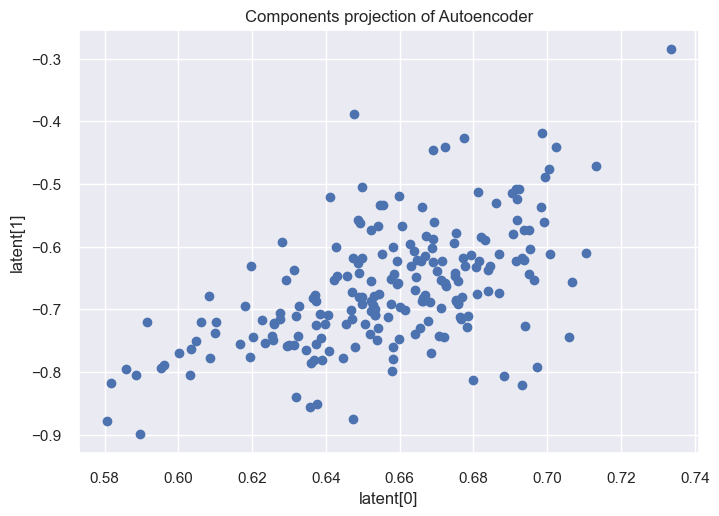

In [31]:
plt.scatter(latent.T[0], latent.T[1])
plt.xlabel('latent[0]')
plt.ylabel('latent[1]')
plt.title('Components projection of Autoencoder')

plt.show()